Fast electrons - EELS mappings
=========================================
*Example authors: A. Arbouet / P. R. Wiecha*  (*electron* submodule by A. Arbouet)

<span style="color: red;">**!!Attention!!**:</span> The *electron* module is still beta functionality and is to be used with caution. 


In this example, we reproduce the results of EELS cartography from *Campos et al.* [1].


[1]: Campos et al.: *Plasmonic Breathing and Edge Modes in Aluminum Nanotriangles* **ACS Photonics** 4(5), 1257 (2017) (https://pubs.acs.org/doi/abs/10.1021/acsphotonics.7b00204)

structure initialization - consistency check: 1225/1225 dipoles valid


/home/hans/.local/lib/python3.8/site-packages/pyGDM2/visu.py:49: UserWarning: 3D data. Falling back to XY projection...
  warnings.warn("3D data. Falling back to XY projection...")


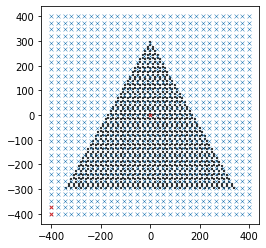

N dipoles: 1225


In [1]:
import matplotlib.pyplot as plt
import numpy as np

from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields
from pyGDM2 import core
from pyGDM2 import propagators
from pyGDM2 import electron
from pyGDM2 import tools
from pyGDM2 import visu


#****************************************************
#          SETTING PARAMETERS FOR ELECTRONS
#****************************************************
Eelec = 100.   # electron kinetic energy (keV)
kSign = 1      # Electron propagation direction

## 2D rasterscan 
xmin,xmax,NX = -400, 400, 31
ymin,ymax,NY = -400, 400, 31


#****************************************************
#         nanostructure
#****************************************************
mesh = 'hex'
step = 20

## note: set H=3 for conditions in Campos et al. ACS Photonics 4(5), Pp.1257 (2017)
geometry = structures.prism(step, NSIDE=35, H=2, mesh=mesh, ORIENTATION=1) 
geometry = structures.center_struct(geometry)
material = materials.alu()

struct = structures.struct(step, geometry, material)


#****************************************************
#         Incident field rasterscan
#****************************************************
field_generator = fields.fast_electron
wavelengths = [850]

## ---------- Generate positions for raster-scan, aligned with structure mesh
_r_probe_2d = tools.generate_NF_map(xmin,xmax,NX, ymin,ymax,NY, Z0=0)
r_probe_2d = tools.adapt_map_to_structure_mesh(_r_probe_2d, geometry)  # dont fill above structure --> faster but less smooth

kwargs_ebeam_2d = []
for x,y in r_probe_2d[:2].T:
   kwargs_ebeam_2d.append(dict(kSign=kSign, electron_kinetic_energy=Eelec,
                               x0=x, y0=y))

efield_2d_scan = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs_ebeam_2d)


#****************************************************
#         environment (--> used Green's tensors)
#****************************************************
n3 = 1.0  # cladding layer
n2 = 1.0  # environment
n1 = 2.0  # substrate environment
spacing = 10000.

dyads = propagators.DyadsQuasistatic123(n1, n2, n3, spacing=spacing)


#****************************************************
#         Simulation Initialization
#****************************************************
sim_2Dscan = core.simulation(struct=struct, efield=efield_2d_scan, dyads=dyads)


plt.subplot(111, aspect='equal')
visu.structure(sim_2Dscan, scale=0.5, show=0)
plt.scatter(_r_probe_2d.T[0], _r_probe_2d.T[1], s=15, lw=0.5, marker='x')
plt.scatter(r_probe_2d.T[0], r_probe_2d.T[1], s=10, lw=1, marker='x', color='C3')
plt.show()

print("N dipoles:", len(sim_2Dscan.struct.geometry))

run the simulation
--------------------------------

Now we run the simulation, calculating EELS spectra at the two indicated positions

In [2]:
## run the simulation
sim_2Dscan.scatter()

/home/hans/.local/lib/python3.8/site-packages/numba/core/dispatcher.py:237: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  entrypoints.init_all()


timing for wl=850.00nm - setup: EE 5369.9ms, inv.: 1264.8ms, repropa.: 42600.9ms (959 field configs), tot: 49235.9ms


1

Plot the EELS mapping
--------------------------------

Comparison with the reference gives a very good agreement

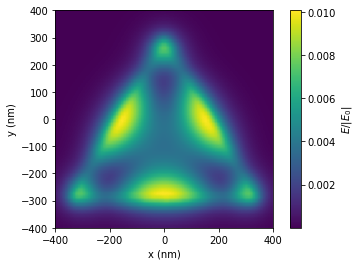

In [3]:
map_pos, EELS_map = tools.calculate_rasterscan(sim_2Dscan, 0, electron.EELS, 
                                               key_x_pos='x0', key_y_pos='y0')
visu.scalarfield([map_pos, EELS_map])